In [135]:
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
import os

def extract_features_vgg16(images_directory, features_directory): # Include / at the end of both paths
    image_names = os.listdir(images_directory)
    model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3)) # load in model
    feature_names = ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3'] # pick which feature maps to save
    model_extract_features = Model(inputs=model.input, # create model that extracts features
                                  outputs=[model.get_layer(feature_name).output for feature_name in feature_names])
    for image_name in image_names: # preprocess and save selected features from each image into features_directory
        x = image.load_img(images_directory + image_name)
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features_list = model_extract_features.predict(x)
        for i in range(len(features_list)):
            np.save(features_directory + image_name.split('.')[0] + "_feature_{}.npy".format(i), features_list[i])
            features_list[i] = features_list[i].tolist()
            
images_directory = './data/conditioned_faces_final/test/'
features_directory = './data/conditioned_faces_final/test_features/'

extract_features_vgg16(images_directory, features_directory)

In [167]:
import numpy as np
import random
import glob
def load_batch_inputs(images_directory, features_directory, batch_size, step_in_epoch, seed_for_epoch):
    random.seed(seed_for_epoch) # Use same seed across epoch
    image_names = np.array(os.listdir(images_directory))
    n_images = len(image_names)
    random_indices = list(range(n_images))
    random.shuffle(random_indices)
    shuffled_image_names = image_names[random_indices]
    image_names_for_batch = shuffled_image_names[batch_size*step_in_epoch:batch_size*(step_in_epoch + 1)]
    if len(image_names_for_batch) != batch_size:
        raise ValueError('No more remaining images in epoch, please reduce number of steps per epoch, or the batch size.')
    
    batch_inputs = []
    images = []
    for image_name in image_names_for_batch: # load images
        x = image.load_img(images_directory + image_name)
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        images.append(x)
    
    batch_inputs.append(np.concatenate(images, axis=0))
    
    feature_names_for_batch = []
    for image_name in image_names_for_batch: # get feature names
        feature_names_for_batch.append(glob.glob(features_directory + image_name.split('.')[0] + '*'))
    feature_names_for_batch = np.array(feature_names_for_batch)
        
    for i in range(len(feature_names_for_batch[0])):
        feature = []
        for j in range(len(feature_names_for_batch)):
            feature.append(np.load(feature_names_for_batch[j, i]))
        batch_inputs.append(np.concatenate(feature, axis=0))
    
    return batch_inputs

(2, 256, 256, 3)


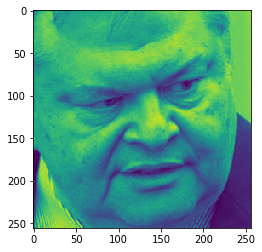

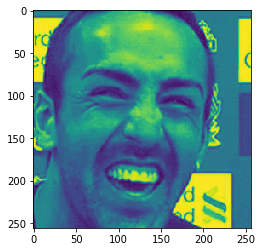

(2, 128, 128, 128)


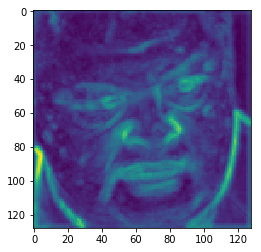

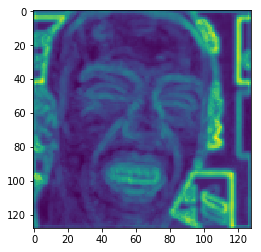

(2, 64, 64, 256)


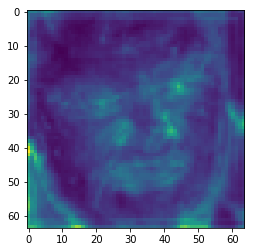

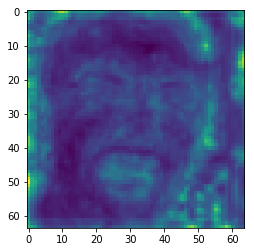

(2, 32, 32, 512)


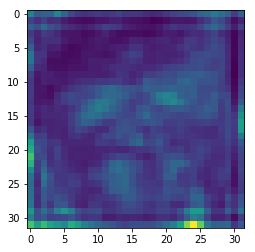

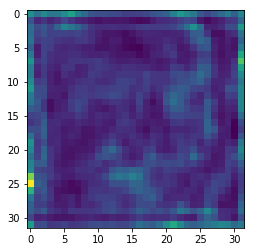

(2, 16, 16, 512)


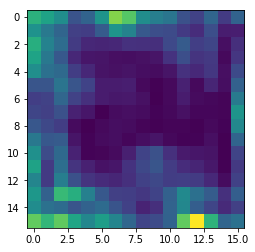

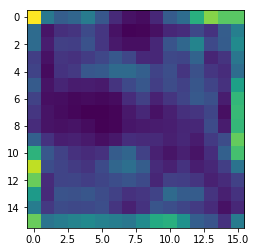

In [172]:
images_directory = './data/conditioned_faces_final/test/'
features_directory = './data/conditioned_faces_final/test_features/'
batch_size = 2
step_in_epoch = 0
seed_for_epoch = 2

minibatch = load_batch_inputs(images_directory, features_directory, batch_size, step_in_epoch, seed_for_epoch)

for mb in minibatch:
    print(mb.shape)
    for i in range(batch_size):
        plt.imshow(np.average(mb[i, :, :, :], axis=2))
        plt.show()